## Neural Architecture Search (NAS) Implementation: Using Bayesian Optimisation as Search Algorithm


**AIM: Build and train an image classifier to detect images from different animal species using a Custom Model derived from NAS in TensorFlow.**

### Objectives

- Data visualisation
- Data preprocessing and image augmentation
- Use NAS to derive an efficient architecture for model development.
- Compile and train the model
- Add early stopping callback (optional)
- Save and load the model
- Model evaluation.
- Make predictions on new data using the trained model.

### Pre-requisite
- Google collaboratry or Jupyter Notebook
- animal-image-classification-dataset
- TensorFlow2

In [1]:
# Import basic libraries
import os
import sys
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib

2026-02-11 20:04:11.835433: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770836651.850299  109347 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770836651.854480  109347 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770836651.864912  109347 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770836651.864929  109347 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770836651.864930  109347 computation_placer.cc:177] computation placer alr

In [2]:
# Set seed for reproducibility

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
# Check GPU availability
!nvidia-smi

Wed Feb 11 20:04:13 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.126.09             Driver Version: 580.126.09     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Quadro RTX 4000                Off |   00000000:01:00.0 Off |                  N/A |
| N/A   61C    P8              6W /  110W |       6MiB /   8192MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
gpus= tf.config.list_physical_devices()

In [5]:
gpus

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
logical_devices = tf.config.list_logical_devices()
logical_devices

I0000 00:00:1770836653.919145  109347 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6624 MB memory:  -> device: 0, name: Quadro RTX 4000, pci bus id: 0000:01:00.0, compute capability: 7.5


[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [7]:
# Check tenorflow version
print("TensorFlow Version", tf.__version__)

TensorFlow Version 2.19.0


In [8]:
## Set the base path
base_dir = "/home/agbor/Public/AI_ML/datasets/dog_vs_cats"
base_dir = pathlib.Path(base_dir)
base_dir

PosixPath('/home/agbor/Public/AI_ML/datasets/dog_vs_cats')

In [9]:
# Train directory
train_dir = base_dir / "train"
train_dir

PosixPath('/home/agbor/Public/AI_ML/datasets/dog_vs_cats/train')

In [10]:
# Validation directory
validation_dir = base_dir / "validation"
validation_dir

PosixPath('/home/agbor/Public/AI_ML/datasets/dog_vs_cats/validation')

In [11]:
# Test directory
test_dir = base_dir / "test"
test_dir

PosixPath('/home/agbor/Public/AI_ML/datasets/dog_vs_cats/test')

In [12]:
## Set Hyperparameters

IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
BATCH_SIZE = 16
EPOCHS = 300

In [13]:
# Load the training dataset

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    seed=SEED,
)

Found 20000 files belonging to 2 classes.


In [14]:
# Load the validation dataset

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    seed=SEED,
)

Found 5000 files belonging to 2 classes.


In [15]:
# Load the validation dataset

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    seed=SEED,
)

Found 12461 files belonging to 2 classes.


In [16]:
# Get the class names
class_names = train_dataset.class_names
class_names

['cats', 'dogs']

In [17]:
# Get the total number of classes
num_classes = len(class_names)
num_classes

2

2026-02-11 20:04:15.294206: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


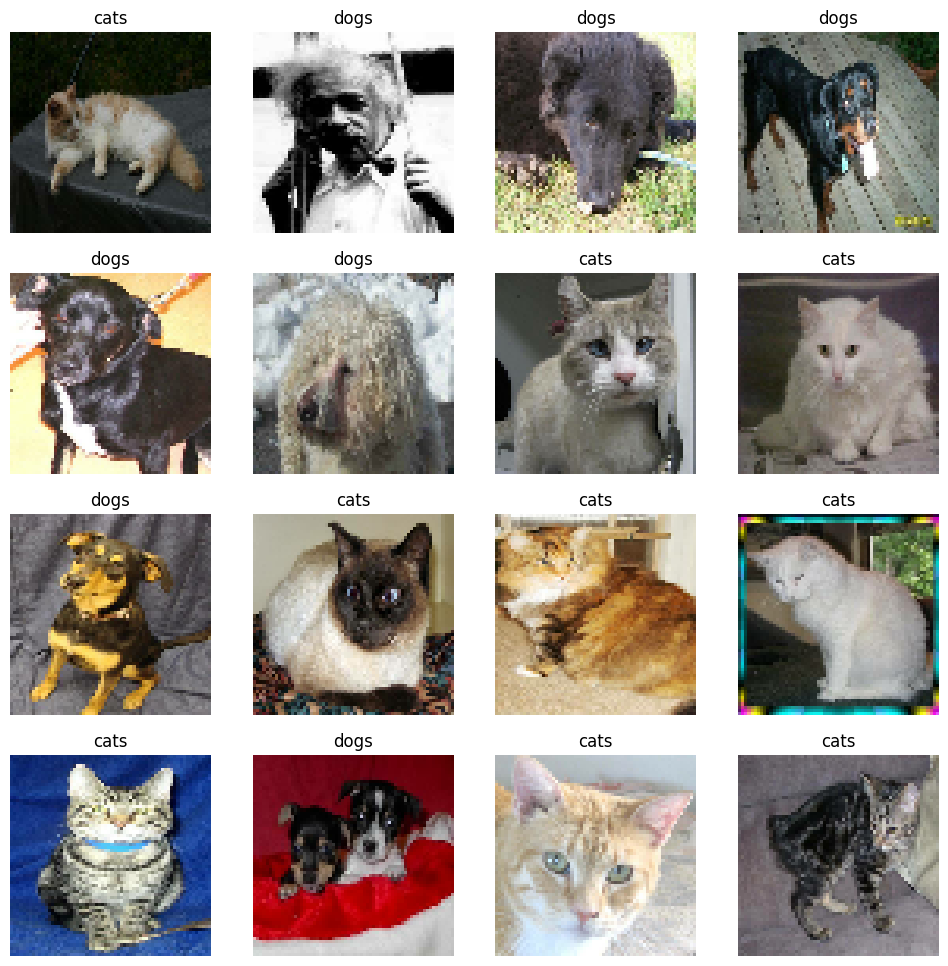

In [18]:
# Sanity check

for images, labels in train_dataset.take(1):
    fixed_images = images.numpy()
    fixed_labels = labels.numpy()


# Visualisations
# No matter how many times you run this cell, the images won change because of teh above

plt.figure(figsize=(12, 12))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(fixed_images[i].astype("uint8"))
    plt.title(class_names[fixed_labels[i]])
    plt.axis("off")

In [19]:
# Performance optimization

### Vanilla MobileNetV2 Implementation

In [20]:
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH) + (3, )
INPUT_SHAPE

(64, 64, 3)

### Performance Optimisation

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

### Data Augmentation Step

In [22]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    # tf.keras.layers.RandomTranslation(0.15, 0.15),
    # tf.keras.layers.RandomContrast(0.25),
    # tf.keras.layers.RandomBrightness(0.2),
    # tf.keras.layers.GaussianNoise(0.05),
    # tf.keras.layers.RandomErasing(),
])


### Neural Architecture Search Implementation

In [23]:
# Inputs (see the input shape)
inputs = tf.keras.layers.Input(shape=INPUT_SHAPE)
inputs

<KerasTensor shape=(None, 64, 64, 3), dtype=float32, sparse=False, ragged=False, name=keras_tensor>

#### (a). Define Search Space (Model Builder Function)

In [24]:
# Hypermodel - defines the search space

def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=INPUT_SHAPE))

    # Data augmentation inside model (good for .fit)
    model.add(data_augmentation)

    num_conv_layers = hp.Int("num_conv_layers", 
                             min_value=2, 
                             max_value=5,
                             step=1)

    for i in range(num_conv_layers):
        model.add(tf.keras.layers.Conv2D(
            filters = hp.Int(f"filters_{i}", 32, 256, step=32),
            kernel_size = hp.Choice(f"kernel_{i}", [3, 5]),
            padding="same",
            activation="relu"
        ))

        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.MaxPooling2D())

    model.add(tf.keras.layers.GlobalAveragePooling2D())

    # Dense Search
    dense_units = hp.Int("dense_units", 128, 512, step=64)
    model.add(
        tf.keras.layers.Dense(units=dense_units, activation="relu")
    )

    model.add(tf.keras.layers.Dense(dense_units, activation="relu"))
    model.add(tf.keras.layers.Dropout(
        hp.Float("dropout", 0.0, 0.5, step=0.1, default=0.2)
    ))


    # Model Output
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

    # Learning Rate
    learning_rate = hp.Choice("learning_rate", values=[1e-2, 5e-3, 1e-3, 5e-4, 1e-4])

    # Compile the model
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss = "binary_crossentropy",
        metrics = ["accuracy"]
    )

    return model

#### Hyperparameter Search (Random Search)

In [25]:
import keras_tuner as kt

tuner = kt.BayesianOptimization(
    hypermodel = build_model,
    objective="val_accuracy",
    max_trials=50,
    directory="smbo_results",
    project_name="dog_vs_cat",
)

#### Starting hyperparameter search ...

In [26]:
# Configure Callbacks

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="models/random_search_nas.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=12,
    verbose=1,
    restore_best_weights=True
)

reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    patience=5,
    factor=0.5,
    min_lr=1e-6,
    verbose=1
)

callbacks = [model_checkpoint, early_stopping, reduce_learning_rate]

#### Start Architecture Search

In [27]:
tuner.search(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
    verbose=1
)

Trial 50 Complete [00h 11m 08s]
val_accuracy: 0.8159999847412109

Best val_accuracy So Far: 0.8284000158309937
Total elapsed time: 06h 09m 03s


#### Get best hyperparameters

In [28]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\n" + "=" * 70)
print("Best Hyperparameters Found:")
for key, value in best_hps.values.items():
    print(f"    {key: <20}: {value}")
print("=" * 70)



Best Hyperparameters Found:
    num_conv_layers     : 5
    filters_0           : 224
    kernel_0            : 3
    filters_1           : 256
    kernel_1            : 5
    dense_units         : 320
    dropout             : 0.30000000000000004
    learning_rate       : 0.0001
    filters_2           : 128
    kernel_2            : 3
    filters_3           : 128
    kernel_3            : 5
    filters_4           : 96
    kernel_4            : 5


#### Show Best CNN Architecture Found

In [29]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

/home/agbor/anaconda3/envs/tf/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 224)    │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 224)    │           896 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 224)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 256)    │     1,433,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 128)      │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 96)       │       307,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 4, 96)       │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 96)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 320)            │        31,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 320)            │       102,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           321 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,589,601 (9.88 MB)

 Trainable params: 2,587,937 (9.87 MB)

 Non-trainable params: 1,664 (6.50 KB)

#### Print Each CNN Layer and Its Parameters

In [30]:
for layer in best_model.layers:
    print(f"Layer: {layer.name}")
    print("  Config:", layer.get_config())


Layer: sequential
  Config: {'name': 'sequential', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 64, 64, 3), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_layer_2', 'optional': False}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Rescaling', 'config': {'name': 'rescaling', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'scale': 0.00392156862745098, 'offset': 0.0}, 'registered_name': None, 'build_config': {'input_shape': (None, 64, 64, 3)}}, {'module': 'keras.layers', 'class_name': 'RandomFlip', 'config': {'name': 'random_flip', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'seed': None

#### Save Best Hyperparameters to File

In [31]:
import json

with open("best_nas_hyperparameters.json", "w") as f:
    json.dump(best_hps.values, f, indent=4)
print("Done")

Done


In [32]:
model = best_model

#### Train the best CNN Model Fully

In [33]:
# # Train the Model to learn patterns from the image

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/300
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8601 - loss: 0.3181
Epoch 1: val_accuracy improved from None to 0.81960, saving model to models/random_search_nas.keras

Epoch 1: finished saving model to models/random_search_nas.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 37s 27ms/step - accuracy: 0.8604 - loss: 0.3164 - val_accuracy: 0.8196 - val_loss: 0.3967 - learning_rate: 1.0000e-04
Epoch 2/300
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8627 - loss: 0.3101
Epoch 2: val_accuracy improved from 0.81960 to 0.82100, saving model to models/random_search_nas.keras

Epoch 2: finished saving model to models/random_search_nas.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.8604 - loss: 0.3151 - val_accuracy: 0.8210 - val_loss: 0.4055 - learning_rate: 1.0000e-04
Epoch 3/300
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8657 - loss: 0.3001
Epoch 3: val_accuracy did not improve from 0.82100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step -

In [34]:
def plot_learning_curves(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(len(acc))


    plt.figure(figsize=(18, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Training Accuracy")
    plt.plot(epochs_range, val_acc, label="Validation Accuracy")
    plt.legend()
    plt.title("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Training Loss")
    plt.plot(epochs_range, val_loss, label="Validation Loss")
    plt.legend()
    plt.title("Loss")

    plt.show()


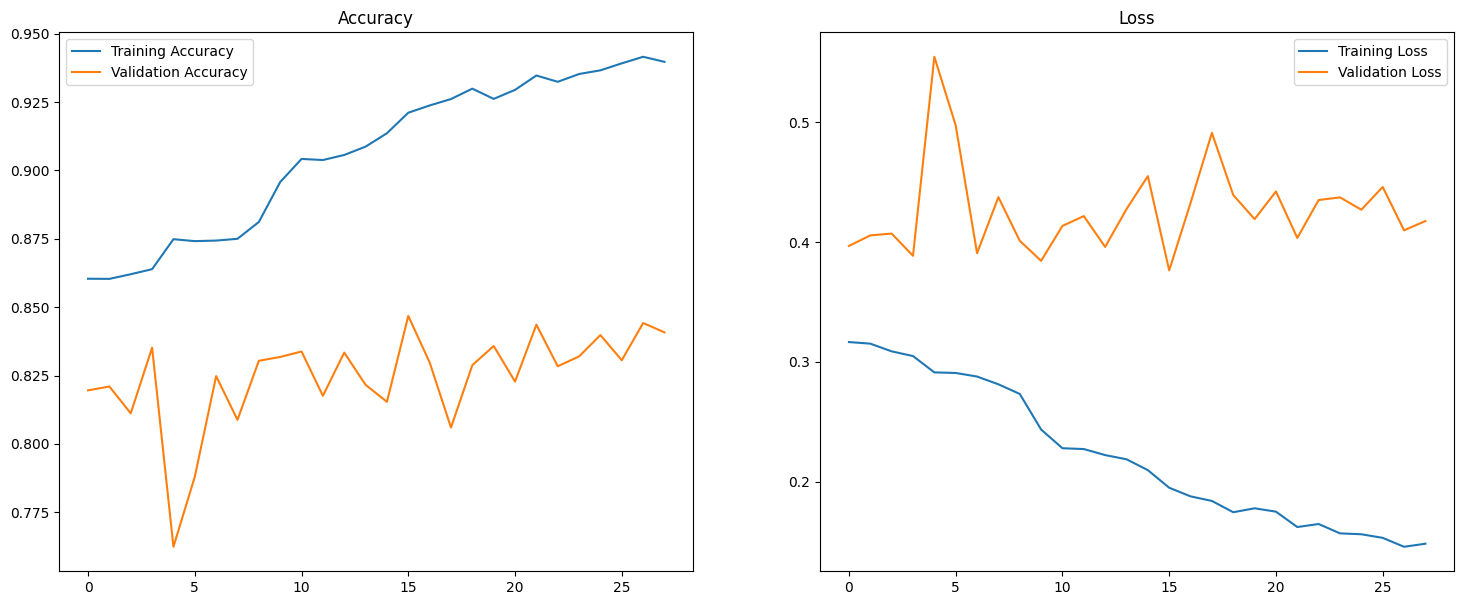

In [35]:
plot_learning_curves(history)

In [36]:
loss, accuracy = model.evaluate(validation_dataset)

print(f"Model Loss: {loss:.2f}")
print(f"Model Accuracy: {accuracy:.2f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8468 - loss: 0.3763
Model Loss: 0.38
Model Accuracy: 0.85
